# 04.6a Deep Space Quasars

**Experiment:** Find the most distant tokens in causal space.

From 04.6, we know the token galaxy has:
- Mean radius: ~50 logometers (from 04.5b)
- Diameter: ~112 logometers (from 04.1)
- Radial variation: 4% CV (very tight shell)

**Hypothesis:** The most distant tokens (causal norm > ~55-60 logometers) are outliers—possibly special tokens like `<|endoftext|>` that serve structural rather than semantic roles.

**Method:**
1. Compute causal norms ||γᵢ||_M for all 152,936 tokens
2. Sort by descending norm
3. Report top 10 most distant tokens
4. Decode and examine them

**If this flunks:** Try tokens closest to origin instead (though these might just be rare/unused tokens).

## Configuration

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and paths
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")

# Analysis parameters
N_TOP = 10  # Number of most distant tokens to report

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

Using device: mps


## Load Model, Tokenizer, and Metric Tensor

In [2]:
# Load metric tensor
print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']
print(f"M shape: {M.shape}")
print()

# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print(f"Vocabulary size: {vocab_size:,} tokens")
print()

# Load tokenizer for decoding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loading causal metric tensor...
M shape: torch.Size([2560, 2560])

Loading Qwen/Qwen3-4B-Instruct-2507...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])
Vocabulary size: 151,936 tokens

Tokenizer loaded.


## Compute Causal Norms for All Tokens

In [3]:
print("Computing causal norms for all tokens...")
print("This may take a minute for 152k tokens...")

# Compute causal norms: sqrt(gamma @ M @ gamma.T) for each row
# Efficient: gamma @ M gives [vocab_size, hidden_dim], then elementwise multiply with gamma and sum
gamma_M = gamma @ M  # [vocab_size, hidden_dim]
causal_norms_squared = (gamma_M * gamma).sum(dim=1)  # [vocab_size]
causal_norms = torch.sqrt(torch.clamp(causal_norms_squared, min=0))  # [vocab_size]

print(f"Computed {len(causal_norms):,} causal norms.")
print(f"  Mean: {causal_norms.mean().item():.4f} logometers")
print(f"  Std:  {causal_norms.std().item():.4f} logometers")
print(f"  Min:  {causal_norms.min().item():.4f} logometers")
print(f"  Max:  {causal_norms.max().item():.4f} logometers")
print()

Computing causal norms for all tokens...
This may take a minute for 152k tokens...
Computed 151,936 causal norms.
  Mean: 54.1318 logometers
  Std:  7.9034 logometers
  Min:  21.3530 logometers
  Max:  85.2873 logometers



## Find Most Distant Tokens

In [4]:
# Sort by causal norm (descending)
sorted_indices = torch.argsort(causal_norms, descending=True)

# Get top N most distant
top_indices = sorted_indices[:N_TOP]
top_norms = causal_norms[top_indices]

print(f"{'='*90}")
print(f"TOP {N_TOP} MOST DISTANT TOKENS (Quasar Candidates)")
print(f"{'='*90}")
print()

for rank, (idx, norm) in enumerate(zip(top_indices, top_norms), 1):
    token_id = idx.item()
    norm_value = norm.item()
    token_str = tokenizer.decode([token_id])
    
    # Repr with escaping for special chars
    token_repr = repr(token_str)
    
    print(f"{rank:2d}. Token ID {token_id:6d} | {norm_value:7.4f} logometers | {token_repr}")

print()
print(f"For context:")
print(f"  Mean causal norm: {causal_norms.mean().item():.4f} logometers")
print(f"  Std deviation:    {causal_norms.std().item():.4f} logometers")
print(f"  Most distant is {(top_norms[0] / causal_norms.mean()).item():.2f}× the mean")

TOP 10 MOST DISTANT TOKENS (Quasar Candidates)

 1. Token ID 151643 | 85.2873 logometers | '<|endoftext|>'
 2. Token ID    198 | 82.0617 logometers | '\n'
 3. Token ID  72363 | 81.1831 logometers | ' \u200b\u200b'
 4. Token ID   4102 | 80.9403 logometers | '\xa0'
 5. Token ID 118174 | 80.0698 logometers | '或多'
 6. Token ID     82 | 76.3415 logometers | 's'
 7. Token ID 109553 | 75.6538 logometers | '和个人'
 8. Token ID  52323 | 75.0789 logometers | 'edly'
 9. Token ID  97322 | 74.6969 logometers | 'edBy'
10. Token ID  38301 | 74.4579 logometers | 'edList'

For context:
  Mean causal norm: 54.1318 logometers
  Std deviation:    7.9034 logometers
  Most distant is 1.58× the mean


## Also Check: Closest Tokens to Origin

In [5]:
# Get bottom N closest to origin
bottom_indices = sorted_indices[-N_TOP:].flip(0)  # Reverse to show smallest first
bottom_norms = causal_norms[bottom_indices]

print(f"{'='*90}")
print(f"TOP {N_TOP} CLOSEST TOKENS TO ORIGIN (Smallest Norms)")
print(f"{'='*90}")
print()

for rank, (idx, norm) in enumerate(zip(bottom_indices, bottom_norms), 1):
    token_id = idx.item()
    norm_value = norm.item()
    token_str = tokenizer.decode([token_id])
    
    token_repr = repr(token_str)
    
    print(f"{rank:2d}. Token ID {token_id:6d} | {norm_value:7.4f} logometers | {token_repr}")

print()
print(f"Closest token is {(bottom_norms[0] / causal_norms.mean()).item():.2f}× the mean")

TOP 10 CLOSEST TOKENS TO ORIGIN (Smallest Norms)

 1. Token ID 150904 | 21.3530 logometers | '듷'
 2. Token ID 103909 | 21.4284 logometers | '�'
 3. Token ID 149801 | 21.4458 logometers | '햑'
 4. Token ID 121774 | 21.4466 logometers | '䦃'
 5. Token ID 149961 | 21.4492 logometers | '�'
 6. Token ID 150112 | 21.4627 logometers | '옼'
 7. Token ID 151000 | 21.4637 logometers | '엃'
 8. Token ID 149802 | 21.4892 logometers | '햤'
 9. Token ID 150905 | 21.5154 logometers | '딮'
10. Token ID 147930 | 21.5233 logometers | '🖏'

Closest token is 0.39× the mean


## Visualize Distribution with Quasars Marked

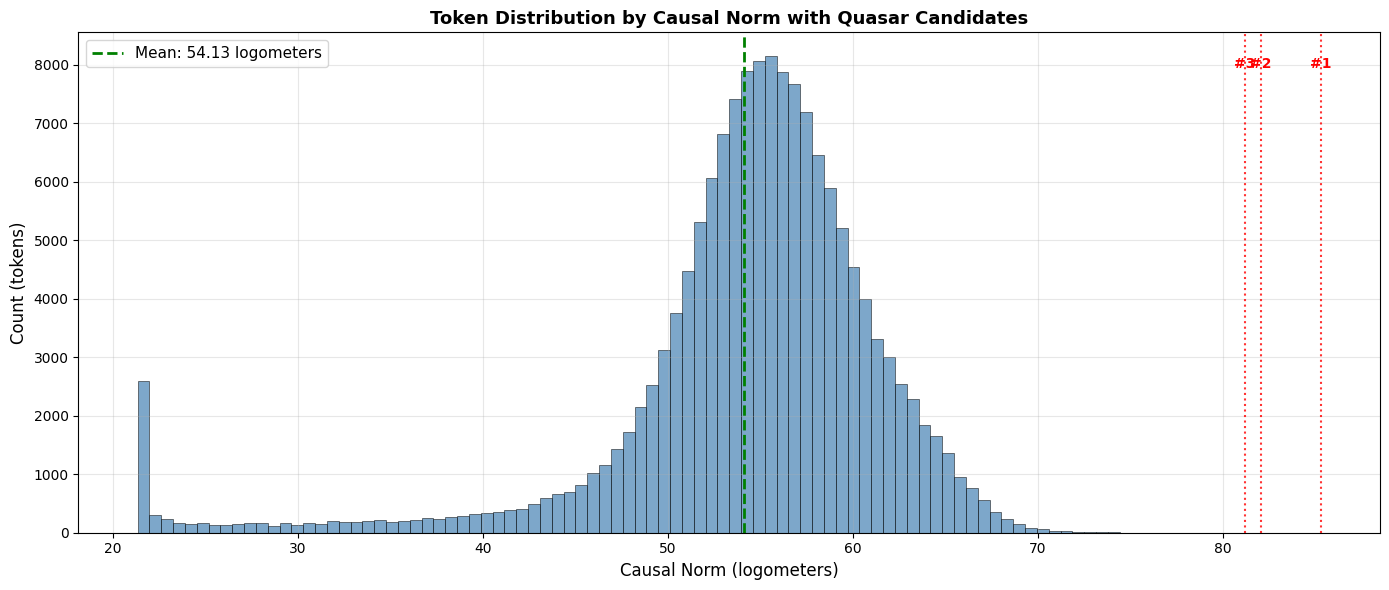

In [6]:
# Convert to numpy for plotting
norms_np = causal_norms.cpu().numpy()
top_norms_np = top_norms.cpu().numpy()

fig, ax = plt.subplots(figsize=(14, 6))

# Histogram of all norms
ax.hist(norms_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Mark mean
mean_norm = norms_np.mean()
ax.axvline(mean_norm, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_norm:.2f} logometers')

# Mark quasar candidates
for i, norm_val in enumerate(top_norms_np[:3], 1):  # Just top 3 to avoid clutter
    ax.axvline(norm_val, color='red', linestyle=':', linewidth=1.5, alpha=0.8)
    ax.text(norm_val, ax.get_ylim()[1] * 0.95, f'#{i}', 
            ha='center', va='top', color='red', fontsize=10, fontweight='bold')

ax.set_xlabel('Causal Norm (logometers)', fontsize=12)
ax.set_ylabel('Count (tokens)', fontsize=12)
ax.set_title('Token Distribution by Causal Norm with Quasar Candidates', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook identified the most distant tokens in causal space—our quasar candidates.

**Next steps:**
- If the top tokens are special tokens (control characters, structural markers), continue to **04.6b** to use the #1 quasar as a reference direction
- If they're not obviously special, examine their semantic properties in **04.6d** (distance-from-quasar as coordinate)
- Map relationships between all special tokens in **04.6c**

**Key question answered:** What are the brightest, most distant stars in our token galaxy?